In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from astropy.io import fits

In [2]:
%matplotlib notebook

# An Introduction to Visualizing Astronomical Images

**Version 0.1**

This session has focused on image processing, with particular attention paid to how we make standard measurements (such as flux or position) in data taken with a wide-field survey, such as the Legacy Survey of Space and Time (LSST) to be conducted by the Vera C. Rubin Observatory. 



Of course, as every good astro-data scientist knows, you should: 

<div align="center">
<br>
<font size="+3"> WORRY ABOUT THE DATA </font>
</div>

When dealing with images, that means *looking at the actual images*. 

This lecture is about the visualization of astronomical images. There are many different aspects that can (should?) be considered within this context. We will focus a primary principle of visualization (recall previous sessions):

  -  Salience - the most important aspects of the figure should stand out

As is often the case when it comes to image processing, Robert Lupton [(Lupton et al. 2004)](https://ui.adsabs.harvard.edu/abs/2004PASP..116..133L/abstract) has written some definitive text on building false color images (we will return to this later). 

* * *

By AA Miller (CIERA/Northwestern & Adler)
2020 July 13

If you haven't already, please [download the images](https://northwestern.box.com/s/bfhgq1jwlz7j69ognvqm5mqpvzm5dbii) that will be necessary for this exercise. Download the entire `data` directory and keep it in the same folder as this notebook. 

Some quick background: these images are taken from the [Zwicky Transient Facilty](https://www.ztf.caltech.edu/).\* ZTF has a 47 $\mathrm{deg}^2$ camera, with $\sim$1 arcsec pixels and $\sim$2 arcsec seeing. It has 3 filters (g, r, i) and has mapped most of the Northern hemisphere. Today we are working with ZTF stacks, roughly 16 individual images has gone into each of these stacks. 

\* Yes, I am biased as a member of ZTF. However, I chose these images because *they aren't all that nice.* SDSS, DES, HSC, PS1, all would have been suitable replacements, typically with better seeing and as a result nicer results. 

## Problem 1) Luminance

We begin by examining how we want to represent the intensity of the light as detected by the ZTF CCD.

**Problem 1a**

Load the data from `data\ztf_i_band.fits.gz` and display a 2D "heatmap" using [`imshow()`](https://matplotlib.org/3.2.2/api/_as_gen/matplotlib.pyplot.imshow.html).

*Note* - CCDs are linear detectors, so use a linear scaling (the default for `imshow()`) of the data in order to "see" what the detector sees.

<IPython.core.display.Javascript object>


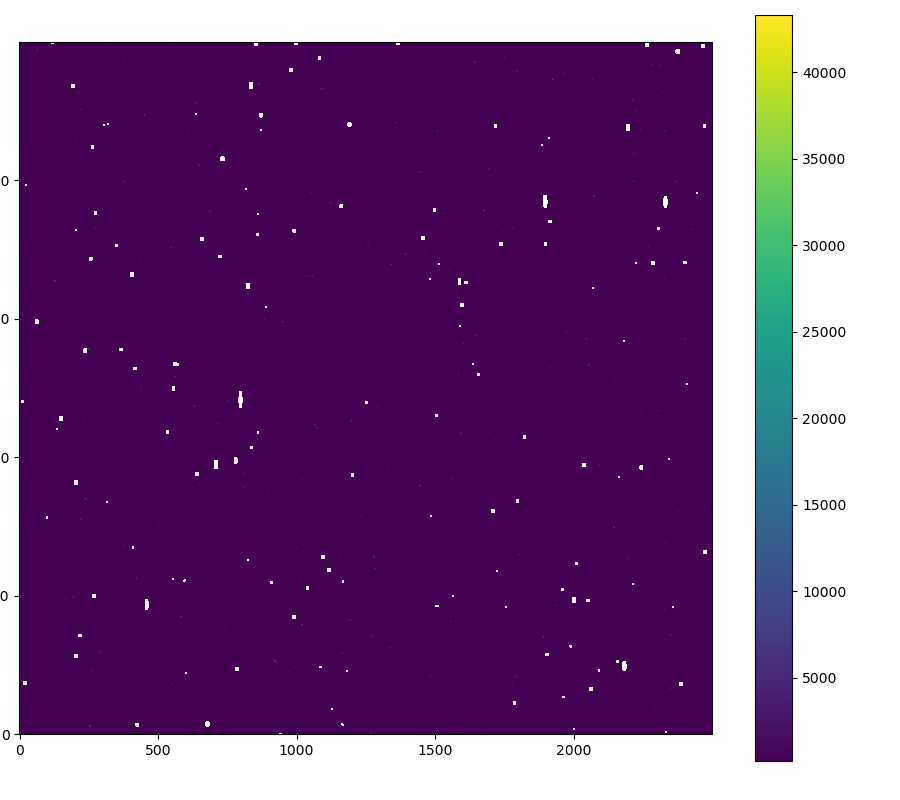

In [5]:
i_data = fits.getdata('./data/ztf_i_band.fits.gz')

fig, ax = plt.subplots(figsize=(9,8))
cax = ax.imshow(i_data, origin='lower')
fig.tight_layout()
fig.colorbar(cax)

The first thing that jumps out of this image is all the white pixels. They all have a value of `nan` because they have been flagged in the ZTF image processing pipeline as unreliable/no good. 

Note - from an aesthic standpoint, you can make these disappear by inputting the following: 

`np.where(np.isnan(i_data), np.nanmedian(i_data), i_data)`

to `imshow()`, which replaces the nan values with the median value from the image. While this is aesthetically more pleasing, it is also misleading as saturation is the main reason pixels will be masked.

We can quickly see the problem with a linear scaling. The dynamic range is too large to reveal any significant structure in the data. We can see the brightest stars, but that is it.

We can adjust the bounds on the plotted distribution to better highlight the salient features in the data.

**Problem 1b**

Make a histogram of the counts in the image. If necessary, adjust the default settings to get a better sense of the distribution. 

*Hint* - be sure to input a 1D array, `i_data` is 2D.

<IPython.core.display.Javascript object>


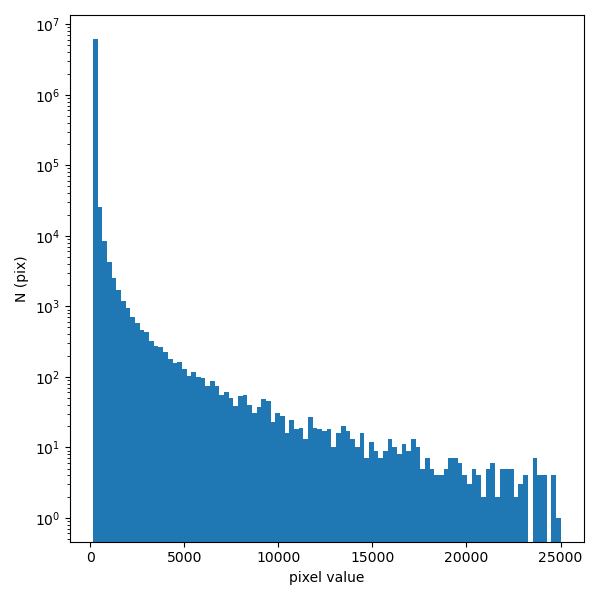

In [16]:
fig, ax = plt.subplots(figsize=(6,6))
ax.hist(i_data.flatten(), 
        range=(150,25000), bins=100)
ax.set_yscale('log')
ax.set_xlabel('pixel value')
ax.set_ylabel('N (pix)')
fig.tight_layout()

We can see a nearly logarithmic distribution, with nearly all the pixels near the "noise floor" of 175 or so, and a large tail to larger values.

Based on this histogram, we will clip the range we show to create better constrast in the visualization.

**Problem 1c**

Replot the i-band image while limiting the range that is displayed to extend from $m$ the minimum pixel value to $M$ the maximum pixel value. While it is possible to do this directly in `imshow()`, use `numpy` to limit the range of what is plotted (the utility of this will become clear later).

<IPython.core.display.Javascript object>


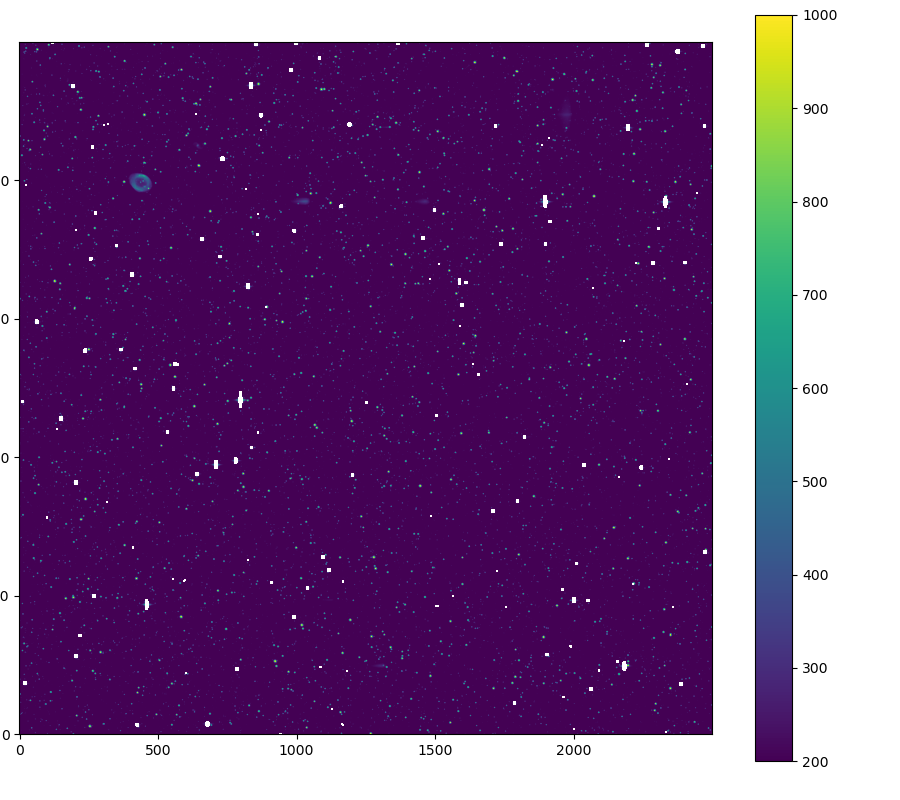

In [21]:
m = 200
M = 1000
i_display = np.clip(i_data, m, M)

fig, ax = plt.subplots(figsize=(9,8))
cax = ax.imshow(i_display, origin='lower')
fig.tight_layout()
fig.colorbar(cax)